In [49]:

filename = "reference_note"

def set_filenames():
    global filename
    global originalMIDI
    global originalTXT
    global originalPNG
    originalMIDI = filename + ".mid"
    originalTXT = filename + ".txt"
    originalPNG = filename + ".png"

set_filenames()
print("original MIDI filename:", originalMIDI)
print("original TXT filename:", originalTXT)
print("original PNG filename:", originalPNG)


original MIDI filename: reference_note.mid
original TXT filename: reference_note.txt
original PNG filename: reference_note.png


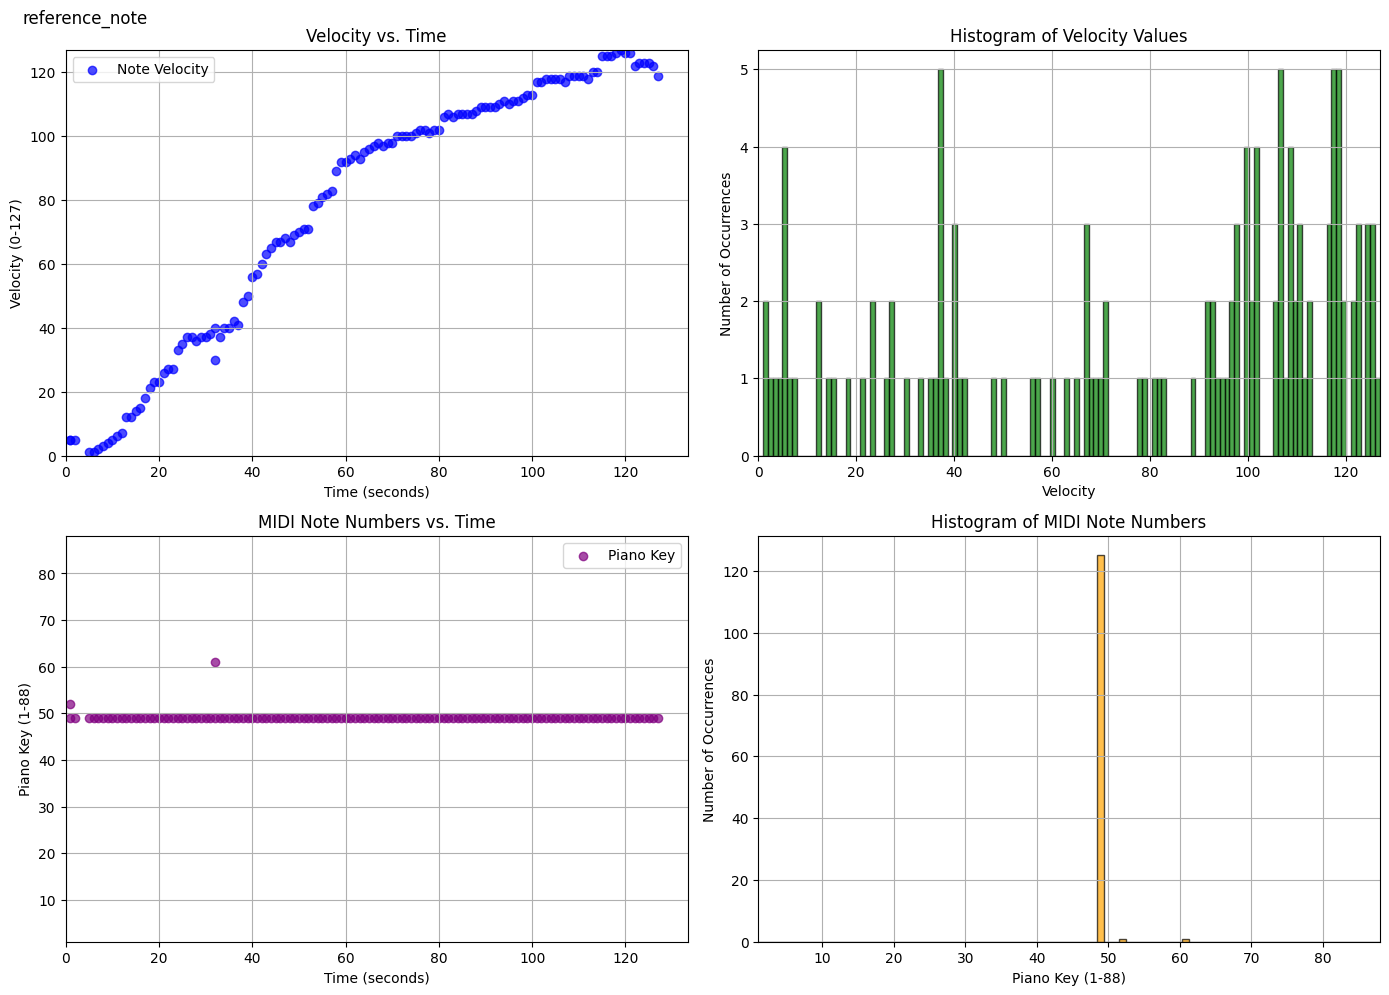

PLOTS saved to: reference_note.png
MIDI events saved to: reference_note.txt


In [50]:
def midi_to_text_and_plot(midi_path, text_path, plot_path, title_text):
    """
    Decodes a MIDI file, writes its events into a text file, and plots:
    1) Velocity vs. Time (ignoring velocity 0) with Y-axis from 0 to 127
    2) Histogram of Velocity Values with 128 bins and X-axis from 0 to 127
    3) MIDI Note Numbers vs. Time mapped to piano keys (1-88)
    4) Histogram of MIDI Note Numbers (mapped to 1-88) with 88 bins
    Args:
        midi_path (str): Path to the input MIDI file.
        text_path (str): Path to save the output text file.
        plot_path (str): Path to save the generated plot as a PNG file.
        title_text (str): Text to be displayed in the upper left corner of the plot.
    """
    import mido
    import matplotlib.pyplot as plt

    midi_file = mido.MidiFile(midi_path)
    ticks_per_beat = midi_file.ticks_per_beat
    tempo = 500000  # Default 120 BPM tempo (500,000 microseconds per beat)

    # Store extracted data
    velocity_values = []
    velocity_times = []
    note_numbers = []
    note_times = []

    with open(text_path, 'w') as text_file:
        text_file.write(f"MIDI File: {midi_path}\n")
        text_file.write(f"Ticks per Beat: {ticks_per_beat}\n\n")

        absolute_ticks = 0  # Tracks cumulative time in ticks

        for i, track in enumerate(midi_file.tracks):
            text_file.write(f"Track {i}: {track.name}\n")
            text_file.write("-" * 40 + "\n")

            for msg in track:
                absolute_ticks += msg.time  # Convert relative to absolute time

                # Tempo Change Handling (Optional)
                if msg.type == 'set_tempo':
                    tempo = msg.tempo  # Set new tempo

                # Convert MIDI ticks to seconds
                seconds = mido.tick2second(absolute_ticks, ticks_per_beat, tempo)

                # Note-On Event (Velocity > 0)
                if msg.type == 'note_on' and msg.velocity > 0:
                    velocity_values.append(msg.velocity)  # Store velocity
                    velocity_times.append(seconds)         # Store time for velocity
                    note_numbers.append(msg.note)            # Store MIDI note number
                    note_times.append(seconds)               # Store time for note

                    text_file.write(f"Time {seconds:.3f} sec | NOTE_ON  | "
                                    f"Note: {msg.note:3d} | Velocity: {msg.velocity:3d}\n")

                # Note-Off Event
                elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                    text_file.write(f"Time {seconds:.3f} sec | NOTE_OFF | "
                                    f"Note: {msg.note:3d} | Velocity: 0\n")

            text_file.write("\n")

    # Map MIDI note numbers to piano keys: MIDI 21 -> 1, MIDI 108 -> 88.
    mapped_note_numbers = [n - 20 for n in note_numbers]

    # Generate Plots as Subplots if there is any velocity data
    if velocity_values:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Top Left: Velocity vs. Time (set Y-axis from 0 to 127)
        axes[0, 0].scatter(velocity_times, velocity_values, color='b', alpha=0.7, label="Note Velocity")
        axes[0, 0].set_xlabel("Time (seconds)")
        axes[0, 0].set_ylabel("Velocity (0-127)")
        axes[0, 0].set_title("Velocity vs. Time")
        axes[0, 0].legend()
        axes[0, 0].grid()
        axes[0, 0].set_ylim(0, 127)
        axes[0, 0].set_xlim(left=0)
        axes[0, 0].text(-0.07, 1.1, title_text, transform=axes[0, 0].transAxes, fontsize=12, verticalalignment='top')

        # Bottom Left: MIDI Note Numbers vs. Time (mapped to 1-88)
        axes[1, 0].scatter(note_times, mapped_note_numbers, color='purple', alpha=0.7, label="Piano Key")
        axes[1, 0].set_xlabel("Time (seconds)")
        axes[1, 0].set_ylabel("Piano Key (1-88)")
        axes[1, 0].set_title("MIDI Note Numbers vs. Time")
        axes[1, 0].legend()
        axes[1, 0].grid()
        axes[1, 0].set_xlim(left=0)
        axes[1, 0].set_ylim(1, 88)

        # Top Right: Histogram of Velocity Values (set X-axis from 0 to 127)
        axes[0, 1].hist(velocity_values, bins=128, range=(0, 127), color='g', alpha=0.7, edgecolor='black')
        axes[0, 1].set_xlabel("Velocity")
        axes[0, 1].set_ylabel("Number of Occurrences")
        axes[0, 1].set_title("Histogram of Velocity Values")
        axes[0, 1].grid()
        axes[0, 1].set_xlim(0, 127)

        # Bottom Right: Histogram of MIDI Note Numbers (mapped to 1-88)
        axes[1, 1].hist(mapped_note_numbers, bins=88, range=(1, 88), color='orange', alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel("Piano Key (1-88)")
        axes[1, 1].set_ylabel("Number of Occurrences")
        axes[1, 1].set_title("Histogram of MIDI Note Numbers")
        axes[1, 1].grid()
        axes[1, 1].set_xlim(1, 88)

        plt.tight_layout()
        plt.savefig(plot_path)  # Save plot as PNG file
        plt.show()

    print(f"PLOTS saved to: {plot_path}")
    print(f"MIDI events saved to: {text_path}")
midi_to_text_and_plot(originalMIDI, originalTXT, originalPNG, filename )

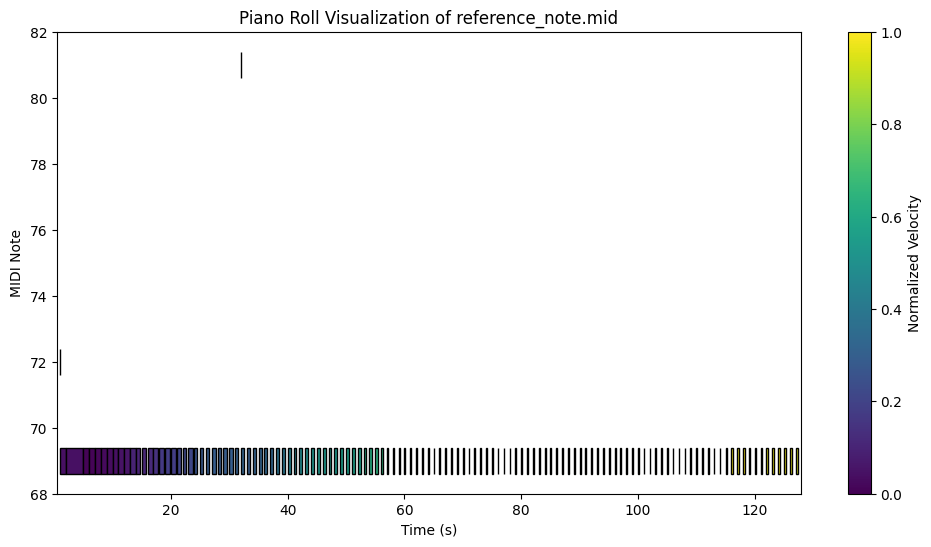

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pretty_midi

def visualize_piano_roll_from_midi():
    """
    Load a MIDI file ("input.mid"), extract note events, and visualize them as a piano roll.
    Each note is drawn as a rectangle from onset to offset time at the pitch corresponding to the MIDI note.
    The rectangle color intensity indicates the normalized note velocity.
    """
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(originalMIDI)
    note_events = []

    # Iterate through all instruments and extract note events
    for instrument in midi_data.instruments:
        # Optionally, skip drum instruments if desired:
        # if instrument.is_drum:
        #     continue
        for note in instrument.notes:
            start = note.start
            end = note.end
            pitch = note.pitch
            # Normalize velocity (MIDI velocities are 0-127)
            velocity = note.velocity / 127.0  
            note_events.append([start, end, pitch, velocity])
    
    # Convert the list to a numpy array and ensure it's 2D
    note_events = np.atleast_2d(np.array(note_events))
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.cm.viridis  # colormap for velocity

    # Draw each note as a rectangle
    for note in note_events:
        onset, offset, midi_note, velocity = note
        duration = offset - onset
        color = cmap(velocity)
        rect = patches.Rectangle((onset, midi_note - 0.4), duration, 0.8,
                                 linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MIDI Note")
    ax.set_title("Piano Roll Visualization of " + originalMIDI)
    
    # Set x-axis limits based on note onsets and offsets
    time_min = np.min(note_events[:, 0]) - 0.5
    time_max = np.max(note_events[:, 1]) + 0.5
    ax.set_xlim(time_min, time_max)
    
    # Set y-axis limits based on MIDI note numbers
    midi_min = np.min(note_events[:, 2]) - 1
    midi_max = np.max(note_events[:, 2]) + 1
    ax.set_ylim(midi_min, midi_max)
    
    # Add a colorbar to indicate velocity
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Normalized Velocity")
    
    plt.show()

# Call the function to visualize the piano roll from "input.mid"
visualize_piano_roll_from_midi()
